In [1]:
import os
import pickle
import random
import sys
import warnings

sys.path.append(os.path.join(".."))
from src.model_utils import (CroplandDataModule_LSTM,
                            Crop_ConvLSTM,
                            Crop_PL,
                            custom_multiclass_report)

import torch
import torch.nn as nn
from torch.utils.data import DataLoader

import pytorch_lightning as pl
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from pytorch_lightning.callbacks import LearningRateMonitor

/home/crop_dev/miniconda/envs/crop_env/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/home/crop_dev/miniconda/envs/crop_env/lib/python3.10/site-packages/torchvision/image.so: undefined symbol: _ZNK3c107SymBool10guard_boolEPKcl'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


In [57]:
X['Train'][0].shape

(10764884, 12, 10)

In [2]:
# Read dictionary pkl file
with open(os.path.join('..', 'data', 'processed_files', 'pkls', 'X_FR_RUS_ROS_lstm.pkl'), "rb") as fp:
    X = pickle.load(fp)

with open(os.path.join('..', 'data', 'processed_files', 'pkls', 'y_FR_RUS_ROS_lstm.pkl'), "rb") as fp:
    y = pickle.load(fp)

In [45]:
# initilize data module
dm = CroplandDataModule_LSTM(X=X, y=y, batch_size=1024)

# initilize model
warnings.filterwarnings("ignore")
torch.manual_seed(123)
random.seed(123)
            
network = Crop_ConvLSTM(
    input_dim=1, #fictional dimension. will be used as channnels
    hidden_dim=16,
    kernel_size=(3,),
    n_layers=1,
    n_classes = 4,
    seq_len = X['Train'][0].shape[2],
    time_len = X['Train'][0].shape[1],
    n_static_features = X['Train'][1].shape[1],
    bias=False,
    return_all_layers=False
    )

model = Crop_PL(net=network)

# initilize trainer
early_stop_callback = EarlyStopping(
    monitor="val/loss",
    min_delta=1e-4, patience=30, verbose=True, mode="min"
)
lr_monitor = LearningRateMonitor(logging_interval="epoch")

trainer = pl.Trainer(
    max_epochs=50,
    accelerator="gpu",
    precision=16,
    devices=[1],
    benchmark=True,
    check_val_every_n_epoch=1,
    callbacks=[early_stop_callback, lr_monitor],
)
trainer.fit(model, dm)

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]

   | Name                | Type                       | Params
--------------------------------------------------------------------
0  | net                 | Crop_ConvLSTM              | 11.1 K
1  | train_loss          | MeanMetric                 | 0     
2  | val_loss            | MeanMetric                 | 0     
3  | test_loss           | MeanMetric                 | 0     
4  | val_F1Score_best    | MaxMetric                  | 0     
5  | train_accuracy      | MulticlassAccuracy         | 0     
6  | val_accuracy        | MulticlassAccuracy         | 0     
7  | test_accuracy       | MulticlassAccuracy         | 0     
8  | train_avg_precision | MulticlassAveragePrecision | 0     
9  | val_avg_precision   | MulticlassAveragePrecision | 

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val/loss improved. New best score: 1.076


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val/loss improved by 0.062 >= min_delta = 0.0001. New best score: 1.014


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val/loss improved by 0.016 >= min_delta = 0.0001. New best score: 0.998


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Epoch 00017: reducing learning rate of group 0 to 5.0000e-04.


Validation: 0it [00:00, ?it/s]

Metric val/loss improved by 0.017 >= min_delta = 0.0001. New best score: 0.981


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

In [51]:
class CroplandDataset_test(Dataset):
    def __init__(self, X):
        self.X_monthly = X[0]  
        self.X_static = X[1] 
        # self.y = y 

    def __len__(self):
        return len(self.X_monthly)

    def __getitem__(self, idx):
        x_monthly = self.X_monthly[idx]
        x_static = self.X_static[idx]
        # target = self.y[idx]
        
        return (x_monthly, x_static)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]


Predicting: 0it [00:00, ?it/s]

              precision    recall  f1-score   support

           0       0.96      0.54      0.69    175675
           1       0.07      0.53      0.12      2399
           2       0.11      0.36      0.17     12662
           3       0.29      0.63      0.40     27461

    accuracy                           0.54    218197
   macro avg       0.36      0.52      0.35    218197
weighted avg       0.81      0.54      0.62    218197



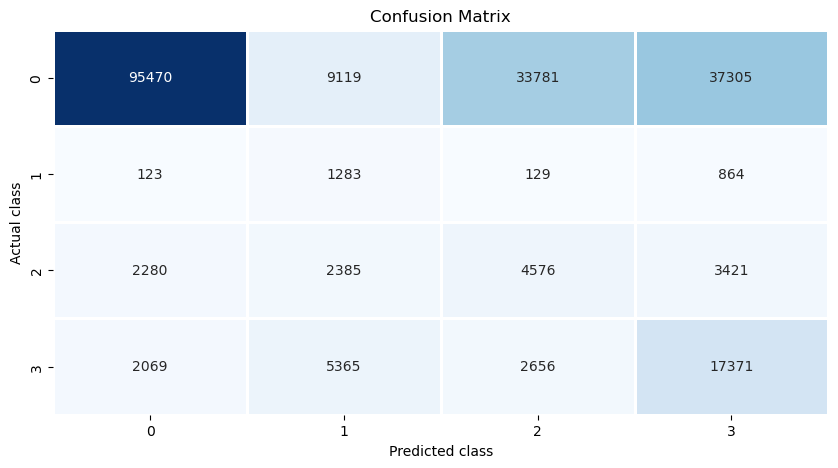

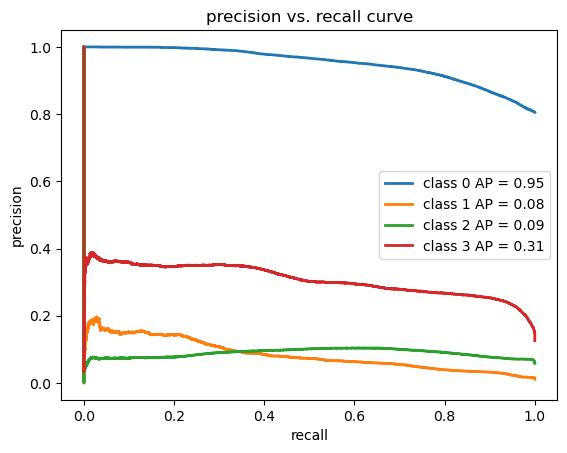

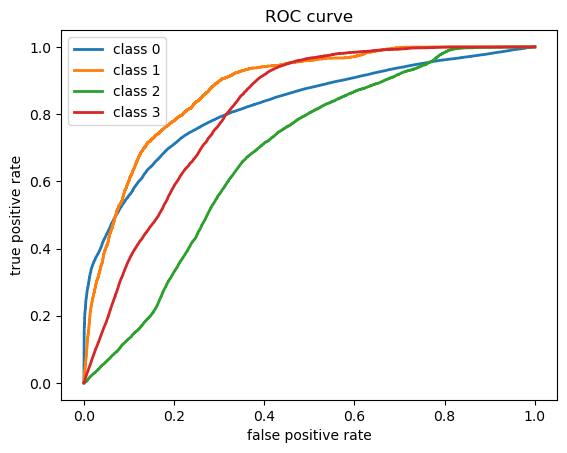

0 ROC AUC OvR: 0.8231
1 ROC AUC OvR: 0.8765
2 ROC AUC OvR: 0.6806
3 ROC AUC OvR: 0.8101
average ROC AUC OvR: 0.7976


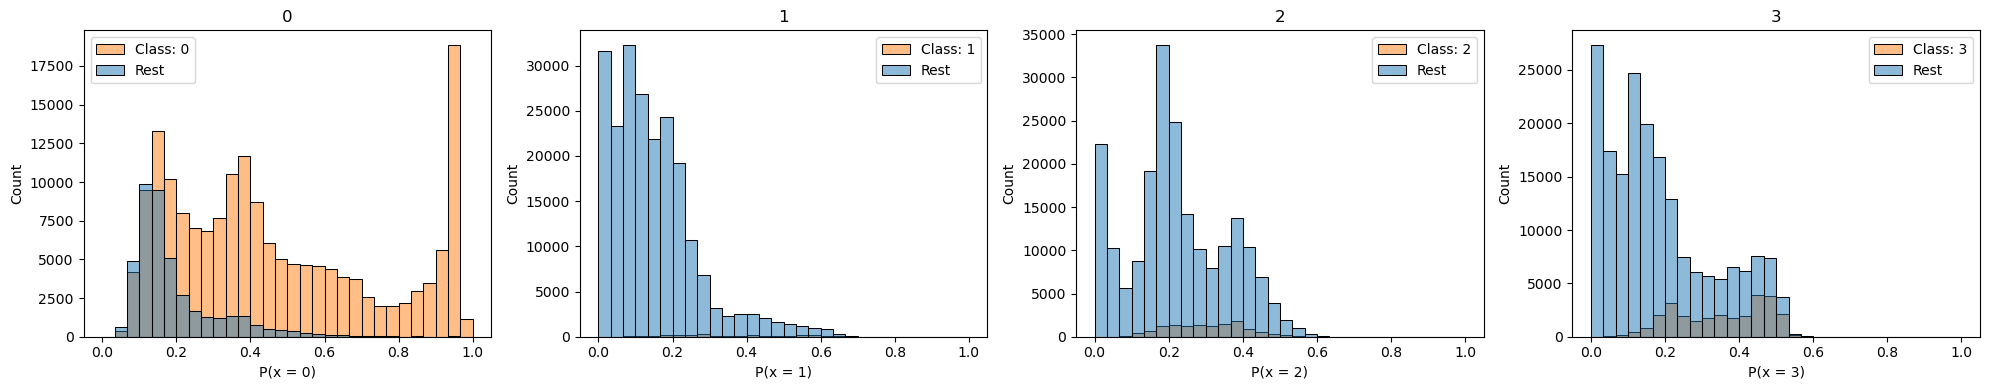

0 vs 1 ROC AUC OvO: 0.8976
1 vs 0 ROC AUC OvO: 0.9072
0 vs 2 ROC AUC OvO: 0.7510
2 vs 0 ROC AUC OvO: 0.6717
0 vs 3 ROC AUC OvO: 0.8498
3 vs 0 ROC AUC OvO: 0.8173
1 vs 2 ROC AUC OvO: 0.7765
2 vs 1 ROC AUC OvO: 0.7580
1 vs 3 ROC AUC OvO: 0.7262
3 vs 1 ROC AUC OvO: 0.6732
2 vs 3 ROC AUC OvO: 0.7307
3 vs 2 ROC AUC OvO: 0.7362
average ROC AUC OvO: 0.7746
None


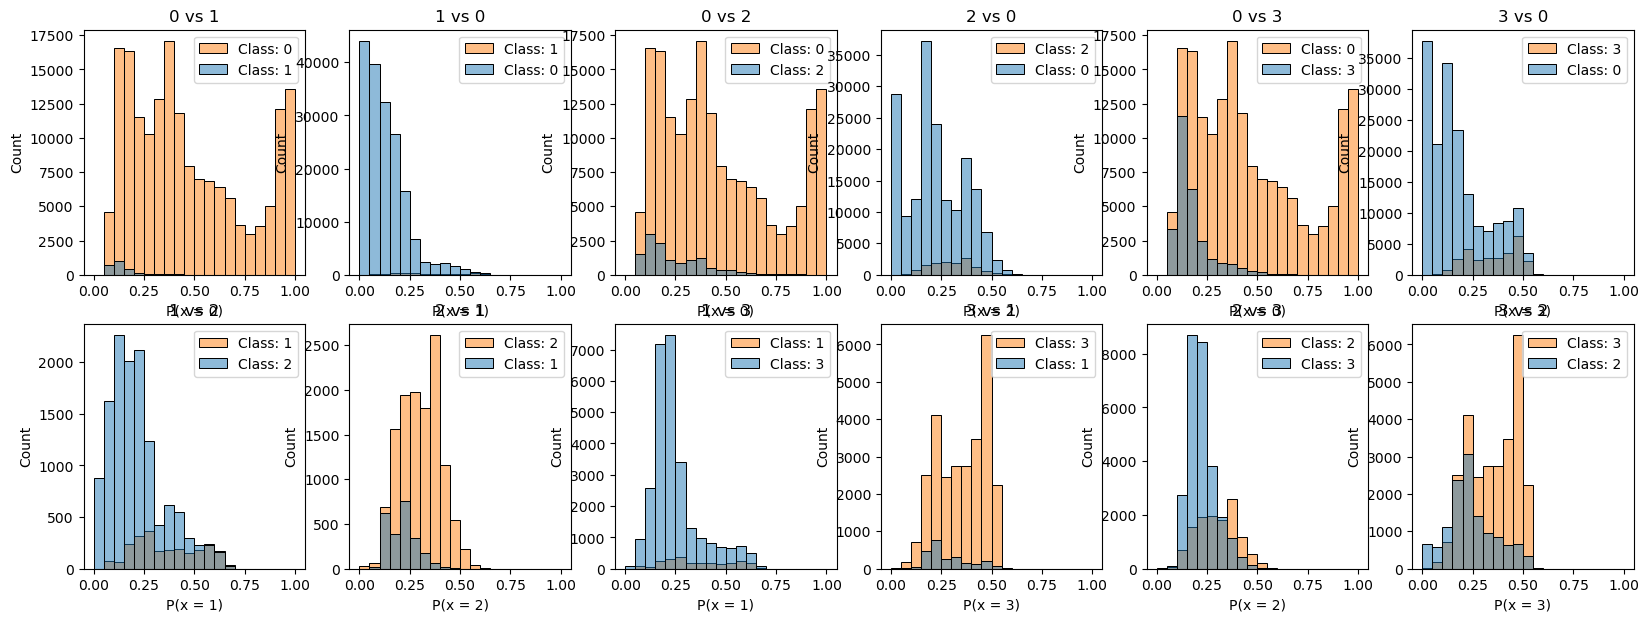

In [56]:
# check metrics
predictions = torch.cat(trainer.predict(model, DataLoader(CroplandDataset_test((dm.X_monthly_test, dm.X_static_test)), batch_size=2048)), dim=0)
softmax = nn.Softmax(dim=1)
yprob = softmax(predictions.float())
ypred = torch.argmax(yprob, 1)
ytest = torch.argmax(dm.y_test, 1).cpu().numpy()


print(custom_multiclass_report(ytest, ypred, yprob))